`Intro to Data Engineering with Snowpark Python`
- https://quickstarts.snowflake.com/guide/data_engineering_with_snowpark_python_intro/index.html?index=..%2F..index#0

`This Quickstart will cover the basics of data engineering with Snowpark for Python`

`Fork the GitHub Repository`
- https://github.com/Snowflake-Labs/sfguide-data-engineering-with-snowpark-python-intro

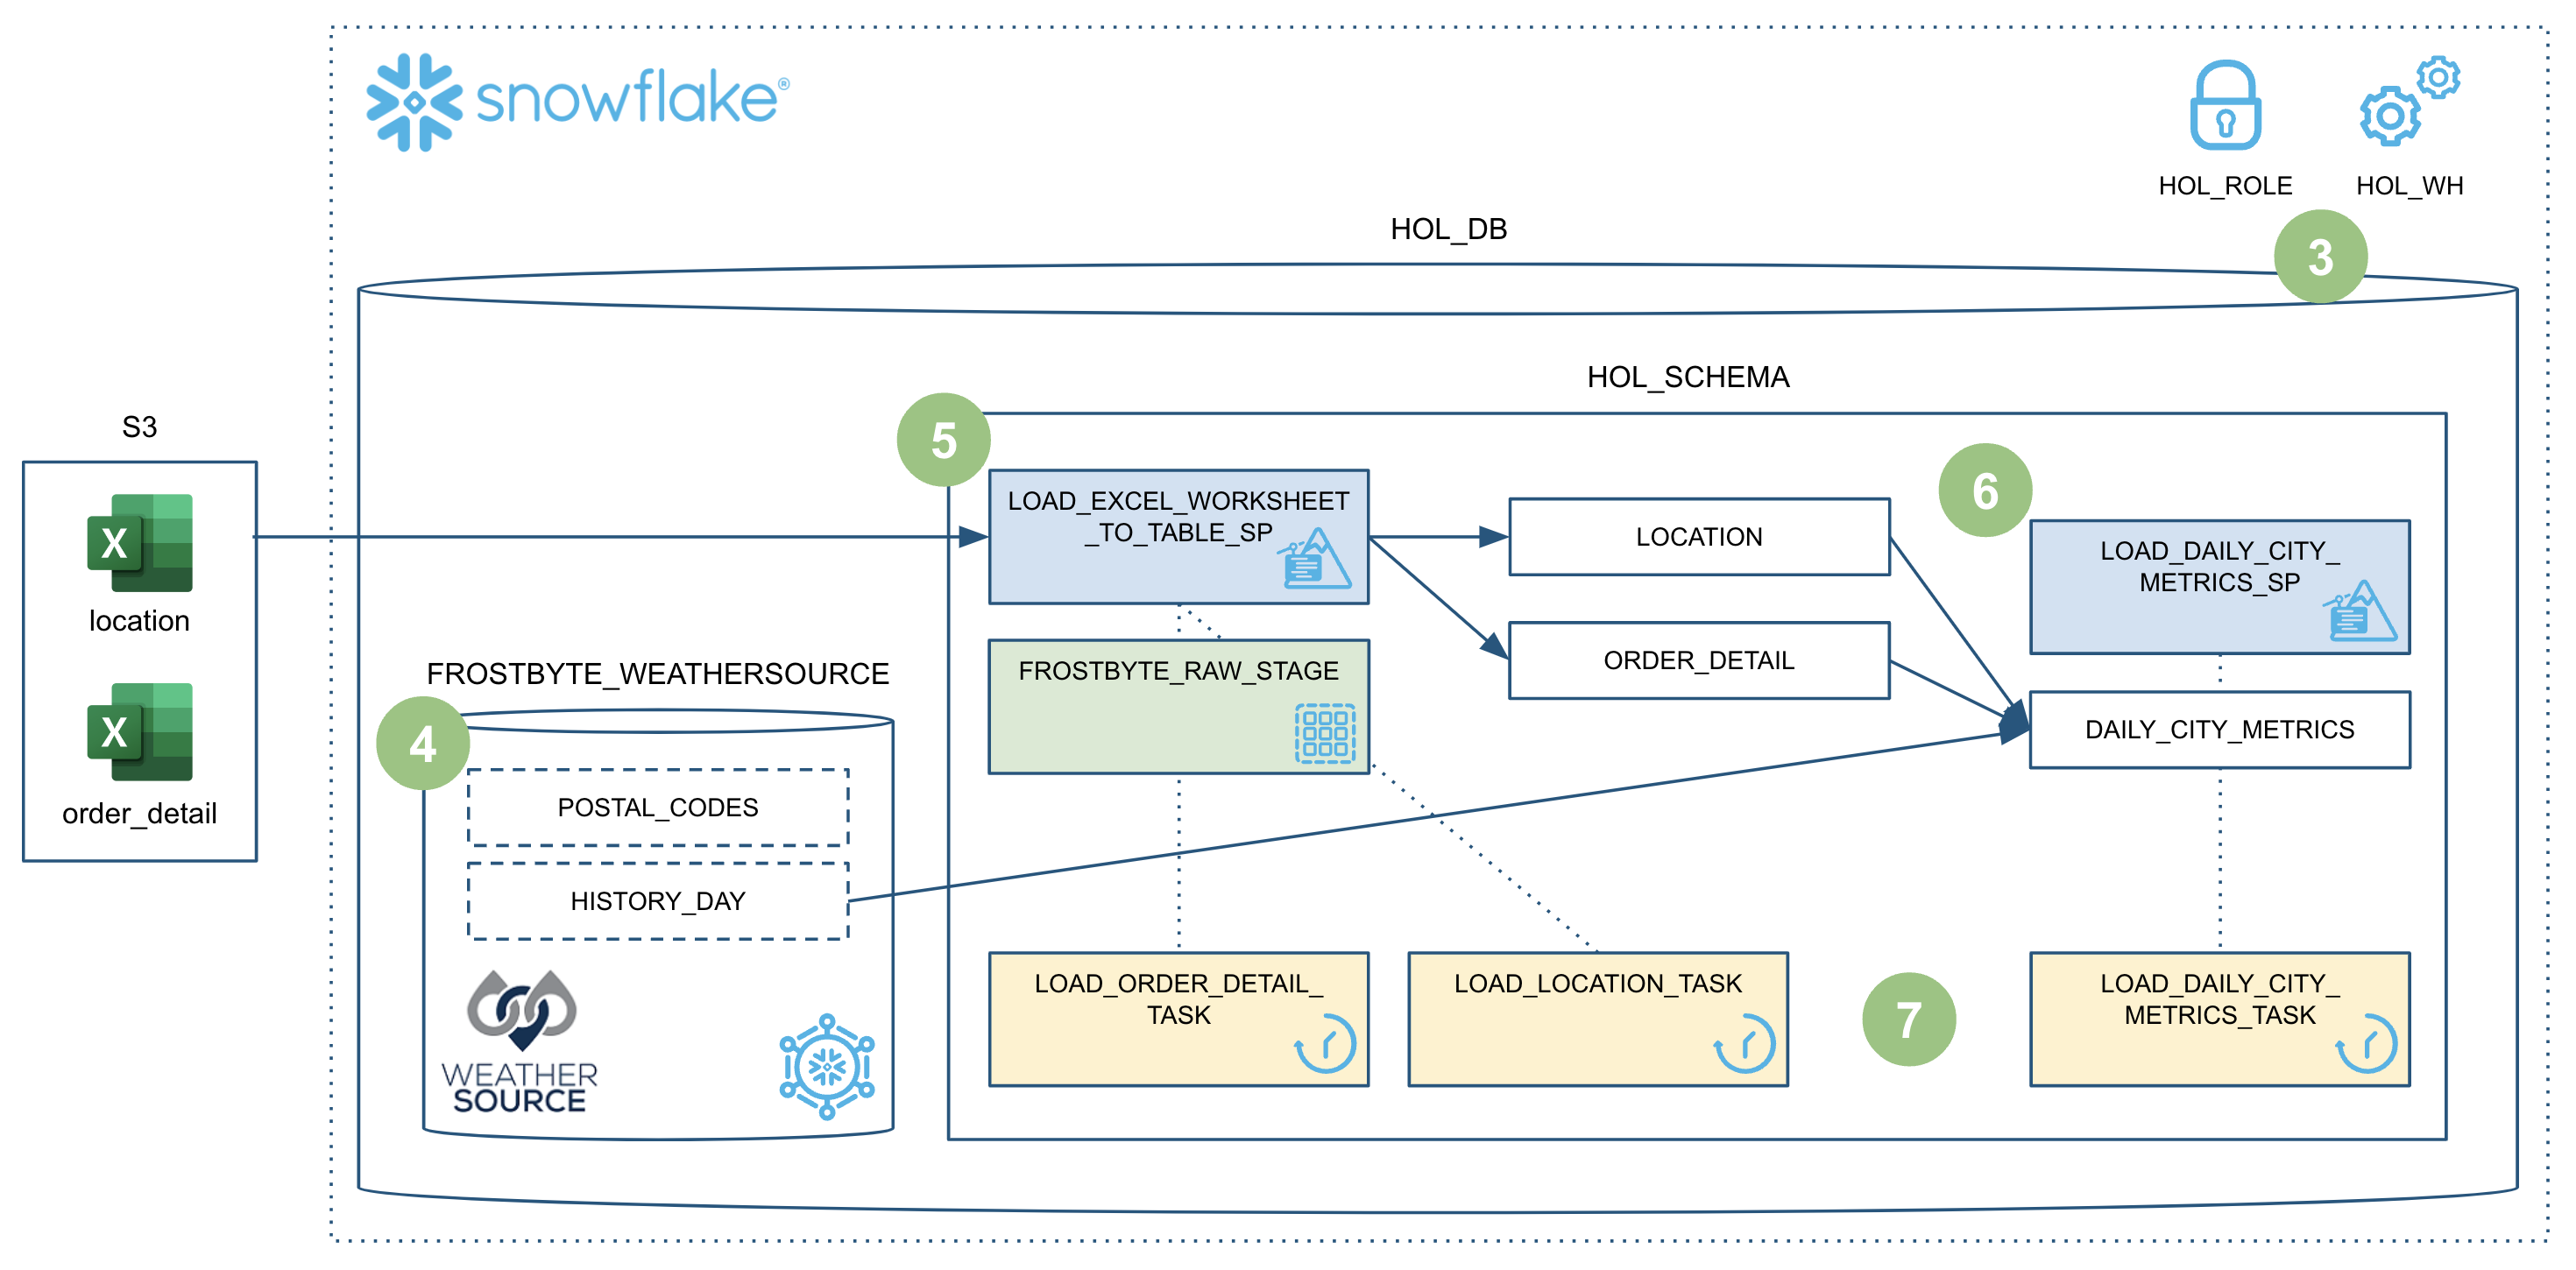

- /snowpark_dataeng/01_setup_snowflake.sql

- /snowpark_dataeng/02_load_weather.sql

- /snowpark_dataeng/03_load_excel_files.sql

- /snowpark_dataeng/04_load_daily_city_metrics.sql

In [89]:
import os
import json
import pandas as pd
import configparser
from snowflake.snowpark import Session
from copy import copy
from snowflake.snowpark import Row
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col, lit, sql_expr, get, get_path, udf, udtf, table_function, sproc, upper, call_function, function, call_udf, builtin
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, DecimalType, LongType
from snowflake.snowpark.exceptions import SnowparkJoinException, SnowparkSQLException
from snowflake.snowpark.files import SnowflakeFile

# Read snowflake credentials securely
config = configparser.ConfigParser()
config.read('credentials.cfg')

connection_parameters = dict(
   account   =  config['SNOWPARKAWS']['SNOWFLAKE_ACCOUNT'],
   user      =  config['SNOWPARKAWS']['SNOWFLAKE_USER'],
   password  =  config['SNOWPARKAWS']['SNOWFLAKE_PASSWORD'],
   role      =  'HOL_ROLE',  # optional
   warehouse =  'HOL_WH',  # optional
   database  =  'HOL_DB',  # optional
   schema    =  'HOL_SCHEMA',  # optional
)

# Pass this dictionary to the Session.builder.configs method to return a builder object that has these connection parameters.
# Call the create method of the builder to establish the session.
session = Session.builder.configs(connection_parameters).create()

In [17]:
session.sql("SELECT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA='HOL_SCHEMA' AND TABLE_NAME='ORDER_DETAIL') AS TABLE_EXISTS").collect()[0]

Row(TABLE_EXISTS=True)

In [18]:
session.sql("SELECT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA='HOL_SCHEMA' AND TABLE_NAME='ORDER_DETAIL') AS TABLE_EXISTS").collect()[0]['TABLE_EXISTS']

True

In [20]:
schema = 'HOL_SCHEMA'
table = 'ORDER_DETAIL'
session.sql("SELECT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA='{}' AND TABLE_NAME='{}') AS TABLE_EXISTS".format(schema, table)).collect()[0]['TABLE_EXISTS']

True

In [57]:
#Define the tables
order_detail = session.table("ORDER_DETAIL")
order_detail.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"            |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"MENU_ITEM_ID"  |"DISCOUNT_ID"  |"QUANTITY"  |"UNIT_PRICE"  |"PRICE"  |"ORDER_ITEM_DISCOUNT_AMOUNT"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
order_detail = session.table("ORDER_DETAIL").select(call_function("DATE", col("ORDER_TS")))
order_detail.show()

------------------------
|"DATE(""ORDER_TS"")"  |
------------------------
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
------------------------



In [55]:
order_detail = session.table("ORDER_DETAIL").select(call_function("DATE", col("ORDER_TS")))
order_detail.show()

------------------------
|"DATE(""ORDER_TS"")"  |
------------------------
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
|2020-10-01            |
------------------------



In [58]:

location = session.table("LOCATION")
location.show()

------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"PLACEKEY"           |"LOCATION"                    |"CITY"     |"REGION"  |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
------------------------------------------------------------------------------------------------------------------------------
|13247          |zzy-22m@nhx-p7k-yjv  |Hugo Boss                     |Melbourne  |Victoria  |AU                  |Australia  |
|8502           |zzy-223@6hq-3gt-djv  |Infineon                      |Tokyo      |Tokyo     |JP                  |Japan      |
|7858           |zzy-222@nhx-p7m-d9z  |Discount Car & Truck Rentals  |Melbourne  |Victoria  |AU                  |Australia  |
|7797           |zzy-222@nhx-p73-xkf  |Hyatt Place                   |Melbourne  |Victoria  |AU                  |Australia  |
---------------------------------------------------------------------------------------------------------------

In [59]:
history_day = session.table("FROSTBYTE_WEATHERSOURCE.ONPOINT_ID.HISTORY_DAY")
history_day.schema.names
#history_day.show()

['POSTAL_CODE',
 'CITY_NAME',
 'COUNTRY',
 'DATE_VALID_STD',
 'DOY_STD',
 'MIN_TEMPERATURE_AIR_2M_F',
 'AVG_TEMPERATURE_AIR_2M_F',
 'MAX_TEMPERATURE_AIR_2M_F',
 'MIN_TEMPERATURE_WETBULB_2M_F',
 'AVG_TEMPERATURE_WETBULB_2M_F',
 'MAX_TEMPERATURE_WETBULB_2M_F',
 'MIN_TEMPERATURE_DEWPOINT_2M_F',
 'AVG_TEMPERATURE_DEWPOINT_2M_F',
 'MAX_TEMPERATURE_DEWPOINT_2M_F',
 'MIN_TEMPERATURE_FEELSLIKE_2M_F',
 'AVG_TEMPERATURE_FEELSLIKE_2M_F',
 'MAX_TEMPERATURE_FEELSLIKE_2M_F',
 'MIN_TEMPERATURE_WINDCHILL_2M_F',
 'AVG_TEMPERATURE_WINDCHILL_2M_F',
 'MAX_TEMPERATURE_WINDCHILL_2M_F',
 'MIN_TEMPERATURE_HEATINDEX_2M_F',
 'AVG_TEMPERATURE_HEATINDEX_2M_F',
 'MAX_TEMPERATURE_HEATINDEX_2M_F',
 'MIN_HUMIDITY_RELATIVE_2M_PCT',
 'AVG_HUMIDITY_RELATIVE_2M_PCT',
 'MAX_HUMIDITY_RELATIVE_2M_PCT',
 'MIN_HUMIDITY_SPECIFIC_2M_GPKG',
 'AVG_HUMIDITY_SPECIFIC_2M_GPKG',
 'MAX_HUMIDITY_SPECIFIC_2M_GPKG',
 'MIN_PRESSURE_2M_MB',
 'AVG_PRESSURE_2M_MB',
 'MAX_PRESSURE_2M_MB',
 'MIN_PRESSURE_TENDENCY_2M_MB',
 'AVG_PRESSURE_TENDENC

In [76]:
order_detail = session.table("ORDER_DETAIL")
location = session.table("LOCATION")
history_day = session.table("FROSTBYTE_WEATHERSOURCE.ONPOINT_ID.HISTORY_DAY")

In [77]:
order_detail = order_detail.join(location, order_detail["LOCATION_ID"] == location["LOCATION_ID"])

In [78]:
order_detail = order_detail.join(history_day, (((call_function("DATE", order_detail["ORDER_TS"])) == history_day["DATE_VALID_STD"]) & (location["ISO_COUNTRY_CODE"] == history_day["COUNTRY"]) & (location["CITY"] == history_day["CITY_NAME"])))


In [83]:
final_agg = (order_detail.group_by(F.col("DATE_VALID_STD")
                                  ,F.col("CITY_NAME")
                                  ,F.col("ISO_COUNTRY_CODE"))
                         .agg(F.sum("PRICE").alias("DAILY_SALES_SUM")
                             ,F.avg("AVG_TEMPERATURE_AIR_2M_F").alias("AVG_TEMPERATURE_F")
                             ,F.avg("TOT_PRECIPITATION_IN").alias("AVG_PRECIPITATION_IN"))
                         .select(F.col("DATE_VALID_STD").alias("DATE")
                                ,F.col("CITY_NAME")
                                ,F.col("ISO_COUNTRY_CODE").alias("COUNTRY_DESC")
                                ,F.call_function("ZEROIFNULL", F.col("DAILY_SALES_SUM")).alias("DAILY_SALES")
                                ,F.round(F.col("AVG_TEMPERATURE_F"), 2).alias("AVG_TEMPERATURE_FAHRENHEIT")
                                ,F.round(F.col("AVG_PRECIPITATION_IN"), 2).alias("AVG_PRECIPITATION_INCHES"))
            )

final_agg.show(10)

-------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"CITY_NAME"  |"COUNTRY_DESC"  |"DAILY_SALES"  |"AVG_TEMPERATURE_FAHRENHEIT"  |"AVG_PRECIPITATION_INCHES"  |
-------------------------------------------------------------------------------------------------------------------------
|2020-10-08  |Tokyo        |JP              |1314027        |58.83                         |1.84                        |
|2020-10-01  |Melbourne    |AU              |33480          |55.31                         |0.00                        |
-------------------------------------------------------------------------------------------------------------------------



In [84]:
for c in final_agg.schema.names:
    print(c)

DATE
CITY_NAME
COUNTRY_DESC
DAILY_SALES
AVG_TEMPERATURE_FAHRENHEIT
AVG_PRECIPITATION_INCHES


In [86]:
[final_agg[c] for c in final_agg.schema.names]

[Column("DATE"),
 Column("CITY_NAME"),
 Column("COUNTRY_DESC"),
 Column("DAILY_SALES"),
 Column("AVG_TEMPERATURE_FAHRENHEIT"),
 Column("AVG_PRECIPITATION_INCHES")]

In [87]:
{c: final_agg[c] for c in final_agg.schema.names}

{'DATE': Column("DATE"),
 'CITY_NAME': Column("CITY_NAME"),
 'COUNTRY_DESC': Column("COUNTRY_DESC"),
 'DAILY_SALES': Column("DAILY_SALES"),
 'AVG_TEMPERATURE_FAHRENHEIT': Column("AVG_TEMPERATURE_FAHRENHEIT"),
 'AVG_PRECIPITATION_INCHES': Column("AVG_PRECIPITATION_INCHES")}